In [146]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [147]:
data = pd.read_parquet('/Users/vittoriomanfriani/Desktop/bonds_us.pq')

In [148]:
data.reset_index(inplace=True)
yields = data.pivot(index='timestamp', columns='id', values='yield')

## YIELDS

In [149]:
# Before proceeding we interpolate nans only if there is one consecutive

# Function to check single NaN in each column
def is_single_nan(series):
    mask = series.isna()
    # Single NaN is identified as a NaN surrounded by non-NaNs
    return mask & ~mask.shift(1, fill_value=False) & ~mask.shift(-1, fill_value=False)

print(f'previous NaNs: {yields.isna().sum().sum()}')
# Mask for single NaNs
single_nan_mask_yields = yields.apply(is_single_nan)

yields = yields.where(~single_nan_mask_yields, yields.interpolate(method='linear', limit=1, axis=0))
print(f'Current NaNs: {yields.isna().sum().sum()}')

previous NaNs: 6871482
Current NaNs: 6871044


<Axes: xlabel='timestamp'>

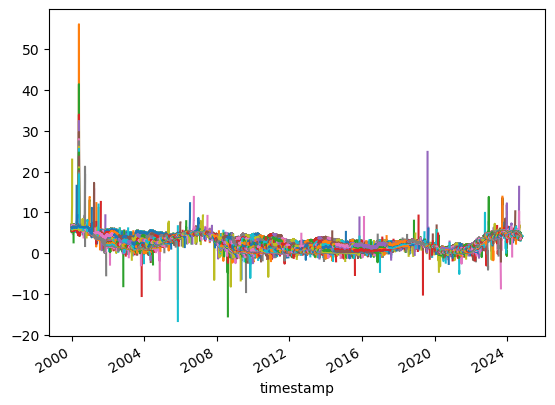

In [150]:
yields.plot(legend = False)

In [151]:
# Function to replace outliers with NaN using custom thresholds
def replace_outliers_with_nan(df, lower_threshold=-1, upper_threshold=12):
    numeric_data = df.select_dtypes(include=[np.number])
    return numeric_data.where((numeric_data >= lower_threshold) & (numeric_data <= upper_threshold), np.nan)

# Copy the dataset and mark only the outliers as NaN
yields = replace_outliers_with_nan(yields)

print(f'previous NaNs: {yields.isna().sum().sum()}')
# Mask for single nan
single_nan_mask_yields = yields.apply(is_single_nan)

yields = yields.where(~single_nan_mask_yields, yields.interpolate(method='linear', limit=3, axis=0))
print(f'Current NaNs: {yields.isna().sum().sum()}')

previous NaNs: 6871293
Current NaNs: 6871220


<Axes: xlabel='timestamp'>

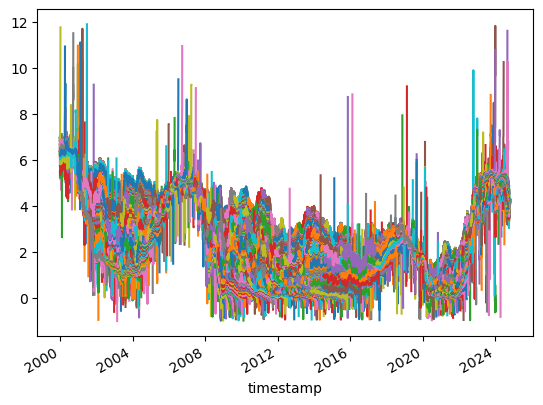

In [152]:
yields.plot(legend = False)

In [156]:
# Function to replace values that deviate by more than 3 standard deviations from the mean
def replace_deviations_with_nan(yields, std1 = 3, std2 = 3):
    for i in range(yields.shape[0]):
        row_mean = yields.iloc[i].mean()
        row_std = yields.iloc[i].std()
        # Replace values deviating more than 3 standard deviations with NaN
        yields.iloc[i] = yields.iloc[i].where(
            (yields.iloc[i] >= row_mean - std1 * row_std) & 
            (yields.iloc[i] <= row_mean +std2 * row_std),
            np.nan
        )
    return yields

# Apply the function to replace outliers with NaNs
yields = replace_deviations_with_nan(yields)

print(f'previous NaNs: {yields.isna().sum().sum()}')
# Mask for multiple Nan (limit = 3)
single_nan_mask_yields = yields.apply(is_single_nan)

yields = yields.where(~single_nan_mask_yields, yields.interpolate(method='linear', limit=3, axis=0))
print(f'current NaNs: {yields.isna().sum().sum()}')

previous NaNs: 6876352
current NaNs: 6876113


<Axes: xlabel='timestamp'>

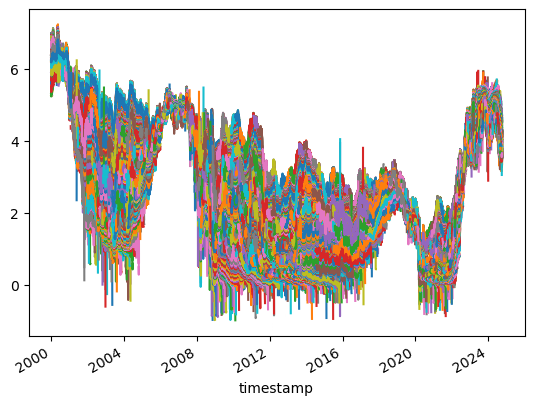

In [157]:
yields.plot(legend = False)

In [158]:
# Compute the mean number of bond outstanding for each trading day
outstanding = []
for i in range(yields.shape[0]):
    yields_dropna = yields.iloc[i].dropna()
    outstanding.append(len(yields_dropna))
np.mean(outstanding)

235.70767093687297

In [159]:
# Convert 'maturity' to datetime
data['maturity'] = pd.to_datetime(data['maturity'], errors='coerce')

# Drop rows where the 'maturity' is NaT (missing)
data = data.dropna(subset=['maturity'])

# Compute time to maturity
data.reset_index(inplace=True)
data['time to maturity'] = (data['maturity'] - data['timestamp']) / pd.Timedelta(days=365.25)

# Get time to maturities dataset
maturities = data.pivot(index='timestamp', columns='id', values='time to maturity')

# Mask single Nan for maturities
single_nan_mask_maturities = maturities.apply(is_single_nan)
maturities = maturities.where(~single_nan_mask_maturities, maturities.interpolate(method='linear', limit=1, axis=0))

In [160]:
# get average range of maturities for each date
maturities_range = []
for i in range(maturities.shape[0]):
    maturities_row = maturities.iloc[i].dropna()
    yields_row = yields.iloc[i].dropna()
    # Align indices of current_yields and current_maturities
    valid_indices = yields_row.index.intersection(maturities_row.index)
    current_yields = yields_row.loc[valid_indices]
    current_maturities = maturities_row.loc[valid_indices]
    maturity_range = np.max(current_maturities) - np.min(current_maturities)
    maturities_range.append(maturity_range)
np.mean(pd.Series(maturities_range).dropna())

29.318553690970127

## PRICES

In [161]:
prices = data.pivot(index='timestamp', columns='id', values='price')

In [162]:
print(f'previous NaNs: {prices.isna().sum().sum()}')
# Mask for single NaNs
single_nan_mask_prices = prices.apply(is_single_nan)

proces = prices.where(~single_nan_mask_prices, prices.interpolate(method='linear', limit=1, axis=0))
print(f'Current NaNs: {prices.isna().sum().sum()}')

previous NaNs: 6871173
Current NaNs: 6871173


In [163]:
prices

id,US912810BU17,US912810BX55,US912810BZ04,US912810CC00,US912810CE65,US912810CG14,US912810CK26,US912810CM81,US912810CP13,US912810CS51,...,US91282CLD10,US91282CLF67,US91282CLG41,US91282CLH24,US91282CLJ89,US91282CLK52,US91282CLL36,US91282CLM19,US91282CLN91,US91282CLP40
timestamp,,,,,,,,,,,,,,,,,,,,,
2000-01-03,100.812500,101.62500,102.734375,104.968750,106.453125,108.453125,114.390625,120.843750,113.890625,128.125000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-04,100.828125,101.87500,103.125000,105.296875,106.796875,108.875000,114.843750,121.421875,114.406250,128.703125,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-05,100.390625,101.68750,102.859375,104.984375,106.453125,108.500000,114.515625,120.953125,113.984375,128.250000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-06,100.828125,101.84375,103.046875,105.218750,106.687500,108.765625,114.796875,121.265625,114.343750,128.625000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-07,100.828125,101.93750,103.078125,105.265625,106.734375,108.875000,114.828125,121.390625,114.437500,128.687500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-11-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-11-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: xlabel='timestamp'>

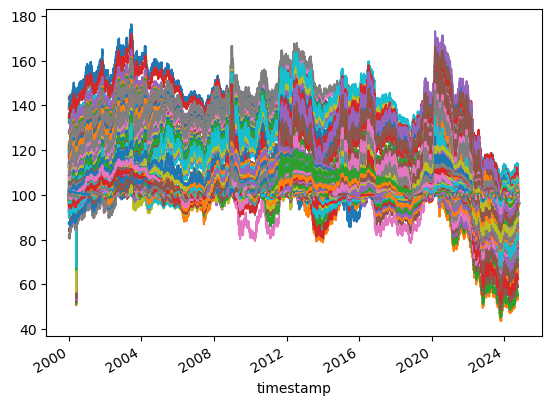

In [164]:
prices.plot(legend = False)

In [165]:
# Apply the function to replace outliers with NaNs
def replace_deviations_with_nan(prices):
    for i in range(prices.shape[1]):
        for j in range(1, prices.shape[0]):
            diff = prices.iloc[j, i] - prices.iloc[j-1, i]
            if abs(diff) > 0.1 * prices.iloc[j-1, i]:
                prices.iloc[j, i] = np.nan       
    return prices

prices = replace_deviations_with_nan(prices)

print(f'previous NaNs: {prices.isna().sum().sum()}')
# Mask for multiple Nan (limit = 3)
single_nan_mask_prices = prices.apply(is_single_nan)

prices = prices.where(~single_nan_mask_prices, prices.interpolate(method='linear', limit=3, axis=0))
print(f'current NaNs: {prices.isna().sum().sum()}')

previous NaNs: 6871189
current NaNs: 6870715


<Axes: xlabel='timestamp'>

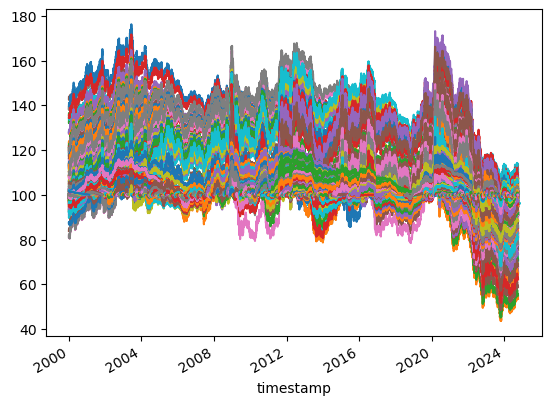

In [166]:
prices.plot(legend = False)

In [168]:
prices.to_csv('prices.csv')